在本章中，我们将：
- 定义一个类来处理模型训练。
- 实现构造方法。
- 了解类的公共、受保护和私有方法之间的区别。

# Imports
整个代码中需要的和任何给定章节中使用的所有库都在一开始就导入了。对于本章，我们需要以下导入：

In [2]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

# Going Classy
## 为模型训练构建类 
到目前为止， %%writefile 方法帮助我们将代码组织成三个不同的部分：数据准备、模型配置和模型训练。不过，在本章末尾，重新思考训练循环，我们遇到了它的一些局限性，例如，如果不编辑模型训练代码，就无法选择不同数量的 epoch。
## The class
让我们开始使用一个相当原始的名称来定义我们的类： StepByStep 。因为我们是从头开始的，所以我们要么不指定父类，要么从基本的 object 类继承它。我更喜欢后者，所以我们的类定义如下所示：
```python
# A completely empty (and useless) class
class StepByStep(object):
	pass
```
## 构造函数
“我们从哪里开始建立一个类？”那将是构造函数； __init__(self) 方法，我们在处理模型和数据集类时已经见过几次。

构造函数定义组成类的部分。这些部分是类的属性。典型的属性包括：
-  用户提供的参数。
-  创建时不可用的其他对象的占位符（非常类似于延迟参数）。
-  我们可能想要跟踪的变量。
-  使用一些参数和高阶函数动态构建的函数。

## Arguments 参数 
让我们从参数开始，这是需要由用户指定的部分。在“重新思考训练循环”这一章的开头，我们问自己：“如果我们使用不同的优化器、损失函数甚至模型，训练循环中的代码会发生变化吗？”答案过去是，现在仍然是，不会改变。因此，**优化器、损失和模型**这三个要素将是我们的主要论点。用户需要指定这些；我们无法自己计算出来。

但是还需要一条信息；用于训练模型的设备。我们不会要求用户通知它，而是会自动检查是否有可用的 GPU，如果没有则回退到 CPU。但是我们仍然希望给用户一个使用不同设备的机会，因此，我们添加了一个非常简单的方法，名为 to ，允许用户指定一个设备。添加所有参数后，我们的构造函数 ( __init__ ) 方法最初将如下所示：

In [3]:
class StepByStep(object):
    #三大参数：模型，损失函数，优化器
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)        

## Placeholders 占位符 
接下来，让我们处理占位符或延迟参数。我们希望用户最终提供其中一些，因为它们不一定是必需的。在我们的课程中，还有另外三个元素属于此类：训练和验证数据加载器以及与 TensorBoard 交互的摘要编写器。带有附加代码的构造函数如下所示：

In [4]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

换句话说，我们的 StepByStep 类由参数、模型、损失函数和优化器的特定组合定义，然后可用于在任何兼容数据集上执行模型训练。验证数据加载器不是必需的（尽管建议使用），摘要编写器绝对是可选的。因此，该类应该实现允许用户稍后通知这些方法的方法。这两个方法都应该放在 StepByStep 类中和构造方法之后：

In [5]:
def set_loaders(self, train_loader, val_loader=None):
    # This method allows the user to define which train_loader 
    # (and val_loader, optionally) to use
    # Both loaders are then assigned to attributes of the class
    # So they can be referred to later
    self.train_loader = train_loader
    self.val_loader = val_loader

def set_tensorboard(self, name, folder='runs'):
    # This method allows the user to create a SummaryWriter to 
    # interface with TensorBoard
    suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    self.writer = SummaryWriter('{}/{}_{}'.format(
        folder, name, suffix
    ))

“为什么我们需要为 val_loader 指定一个默认值？它的占位符值已经是 None 。”由于验证加载器是可选的，因此在方法定义中为特定参数设置默认值可以使用户在调用方法时不必提供该参数。在我们的例子中，最佳默认值与我们在为验证加载器指定占位符时选择的值相同： None 。
## Variables 变量 
然后，我们可能想要跟踪一些变量。典型的例子是 epoch 的数量以及训练和验证损失。这些变量很可能由类在内部计算和更新。带有附加代码的构造函数将如下所示，类似于我们对占位符所做的：

In [6]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

“难道我们不能在第一次使用它们时就设置这些变量吗？”

是的，我们可以，而且我们可能会侥幸逃脱，因为我们的课程非常简单。随着类变得越来越复杂，它可能会导致问题。因此，最好的做法是在构造方法中定义一个类的所有属性。

更新后的 StepByStep 类现在如下所示

In [7]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

# Functions 函数
## 创建函数属性
为方便起见，有时创建作为函数的属性很有用，这些属性将在类内的其他地方调用。在我们的例子中，我们可以使用我们在重新思考训练循环一章中定义的高阶函数（分别是辅助函数#1 和#3）来创建 train_step 和 val_step 。它们都以一个模型、一个损失函数和一个优化器作为参数，所有这些都是我们 StepByStep 类在构造时已知的属性。下面的代码将是我们构造函数方法的最终更新版本：

In [8]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

将所有代码拼凑在一起后，您的 StepByStep 类应该如下所示：

In [9]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)
        
        # These attributes are defined here, but since they are
        # not available at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)        
        
    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

# 不同的方法类型
在上节中，我们介绍了 _make_train_step 和 _make_val_step 方法，并注意到这些方法有一个下划线作为前缀。为什么会这样，这与 __init__ 方法中的双下划线有何不同？”
## 公共、受保护和私有方法 
某些编程语言（如 Java）具有三种方法：公共、受保护和私有.

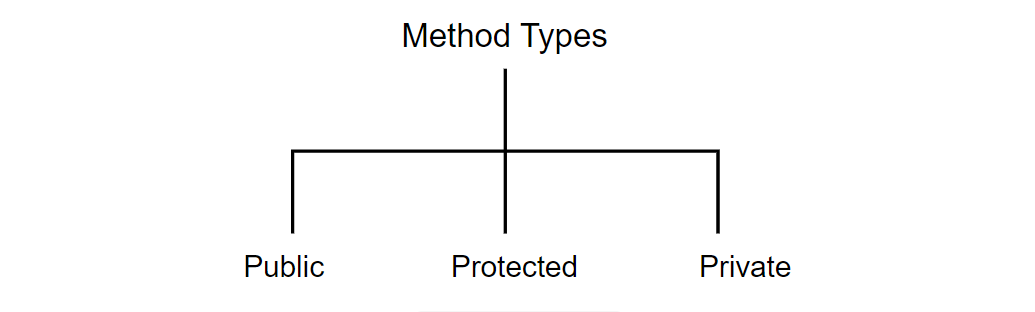

公共方法是您最熟悉的一种；他们可以被用户调用。另一方面，受保护的方法不应由用户调用。它们应该在内部或由子类调用（子类可以从其父类调用受保护的方法）。

最后，私有方法应该只在内部调用。他们甚至应该对子类不可见。

这些规则在 Java 中严格执行，但 Python 采取更宽松的方法；所有方法都是公开的。意思是，你可以调用任何你想要的方法。但是您可以通过在方法名称前加上**单个下划线（对于受保护的方法）**或**双下划线（对于私有方法）**作为前缀来建议适当的用法。这样，用户就知道程序员的意图了。

在我们的示例中， _make_train_step 和 _make_val_step 都被定义为受保护的方法。我们希望用户不要直接调用它们，但如果有人决定定义一个继承自 StepByStep 的类，他们应该觉得有权这样做。

为了使我们的代码的添加看起来更简单，也就是说，不必在每次引入新方法时都复制完整的类，我求助于在常规情况下不应使用的东西： setattr 。这个函数允许我们在运行时动态地添加属性。我们可以使用它来添加我们的 _make_train_step 和 _make_val_step 方法。我们还可以使用它来添加我们的 train_step 和 val_step 方法。这些方法将在我们的训练循环中使用。

In [11]:
# ATTENTION! Using SETATTR for educational purposes only 
setattr(StepByStep, '_make_train_step', _make_train_step)
setattr(StepByStep, '_make_val_step', _make_val_step)

NameError: name '_make_train_step' is not defined

## setattr 是什么？
setattr 函数设置给定对象的指定属性的值。但是方法也是属性，所以我们可以使用这个函数一次性将方法“附加”到现有类及其所有现有实例！你不应该在你的常规代码中使用它！使用 setattr 通过向其附加方法来构建类仅用于教育目的。

为了说明它是如何工作的以及为什么它可能是危险的，将向您展示一个小例子。让我们创建一个简单的 Dog 类，它只接受狗的名字作为参数：

In [12]:
class Dog(object):
    def __init__(self, name):
        self.name = name

接下来，让我们实例化我们的类；也就是说，我们正在创造一只狗。让我们称它为 Rex 。它的名称将存储在 name 属性中：

In [13]:
class Dog(object):
    def __init__(self, name):
        self.name = name

rex = Dog('Rex')
print(rex.name)

Rex


然后，让我们创建一个以 Dog 实例作为参数的 bark 函数，并调用此函数来发出 Rex 吠声：

In [14]:
def bark(dog):
    print('{} barks: "Woof!"'.format(dog.name))

bark(rex)

Rex barks: "Woof!"


但这不是我们想要的。我们希望我们的狗能够开箱即用地吠叫！所以我们将使用 setattr 来赋予狗吠叫的能力。不过有一件事我们需要改变，那就是函数的参数。由于我们希望 bark 函数是 Dog 类本身的一个方法，因此参数需要是该方法自己的实例： self 。

In [15]:
def bark(self):
    print('{} barks: "Woof!"'.format(self.name))

setattr(Dog, 'bark', bark)

它有效吗？让我们创建一只新狗：

In [16]:
def bark(self):
    print('{} barks: "Woof!"'.format(self.name))
#第一个参数是类，第二个参数是方法名，第三个参数是方法
setattr(Dog, 'Bark', bark)

fido = Dog('Fido')
fido.Bark()

Fido barks: "Woof!"


当然，它有效！现在不仅新狗会叫，所有的狗都会叫：

In [17]:
def bark(self):
    print('{} barks: "Woof!"'.format(self.name))

setattr(Dog, 'bark', bark)

rex = Dog('Rex')
rex.bark()

Rex barks: "Woof!"


看？我们一次有效地修改了底层 Dog 类及其所有实例！当然，它看起来很酷。它也会造成严重破坏。使用 setattr 是一种 hack。我们怎么强调都不为过！请不要在常规代码中使用 setattr 。

不像我们目前所做的那样直接在类中创建属性或方法，而是可以使用 setattr 动态创建它们。在我们的 StepByStep 类中，最后两行代码在类中创建了两个方法，每个方法都与用于创建该方法的函数同名。

# 训练方法
## 更新小批量 
我们需要的下一个方法是添加对应于“重新思考训练循环”一章中的辅助函数#2：小批量循环。在将它合并到我们的 StepByStep 类之前，我们需要对其进行一些修改。

在前面的函数中，数据加载器和步骤函数都是参数。但是，情况不再如此，因为我们将它们都作为属性： **self.train_loader 和 self.train_step 用于训练； self.val_loader 和 self.val_step 用于验证**。该方法唯一需要知道的是它是在处理训练数据还是验证数据。更新后的代码应如下所示：

In [ ]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and 
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step = self.val_step
    else:
        data_loader = self.train_loader
        step = self.train_step

    if data_loader is None:
        return None

    # Once the data loader and step function are set, this is the
    # same mini-batch loop we had before
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)
        mini_batch_loss = step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

此外，如果用户决定不提供验证加载器，它将保留来自构造方法的初始 None 值。如果是这种情况，我们就没有相应的损失来计算，而是返回 None （上面代码片段中的第 13 行）。
## 更新训练循环
还剩下什么？当然是训练循环！它将类似于我们在“重新思考训练循环”一章中训练 V5 模型，但我们可以使其更加灵活，将轮数和随机种子作为参数。

这解决了我们在“重新思考训练循环”一章中遇到的问题，当时我们不得不在加载一个检查点后再训练 200 个 epoch，因为它被硬编码到训练循环中。好吧，不再是了！

此外，我们需要确保训练循环的**可重复性**。我们已经设置了种子以确保随机拆分（数据准备）和模型初始化（模型配置）的可重复性。到目前为止，我们按顺序运行整个管道，因此训练循环每次都产生相同的结果。现在，为了在不影响可重复性的情况下获得灵活性，我们需要设置另一个随机种子。

我们正在构建一种仅处理种子设置的方法，遵循 PyTorch 的可重复性指南：

In [18]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
setattr(StepByStep, 'set_seed', set_seed)


具体来说，这段代码将 PyTorch 和 NumPy 的随机数种子都设置为 seed，以保证每次运行时都能产生相同的随机数序列。另外，还将 PyTorch 的一些优化库的行为进行了调整，以确保程序的可复现性。

具体地，torch.backends.cudnn.deterministic 设置为 True 表示启用 CuDNN 的随机数生成器的可重复模式，从而使每次运行时都能产生相同的随机数序列；torch.backends.cudnn.benchmark 设置为 False 表示禁用 CuDNN 的自动调整算法，以保证程序的可复现性；torch.manual_seed(seed) 将 PyTorch 的随机数种子设置为 seed；np.random.seed(seed) 将 NumPy 的随机数种子设置为 seed。这样，每次运行代码时，都会使用相同的随机数种子，从而产生相同的随机数序列。

也是时候使用我们在构造函数方法中定义为属性的变量： self.total_epochs 、 self.losses 和 self.val_losses 。所有这些都在训练循环中更新。

In [ ]:
def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)
    
    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Flushes the writer
        self.writer.flush()
        
setattr(StepByStep, 'train', train)

这段代码定义了 train 方法，用于训练模型。该方法接受两个参数：n_epochs 表示要训练多少个 epoch，seed 表示随机数种子，用于保证训练过程的可重复性。

在方法中，首先通过调用 self.set_seed(seed) 方法设置随机数种子，以确保每次训练的结果是可重复的。然后，使用一个 for 循环迭代执行 n_epochs 次训练。

在循环的每一次迭代中，首先更新 self.total_epochs 属性的值，表示当前已经训练的 epoch 数。然后调用 _mini_batch 方法进行 mini-batch 训练，并将返回的 loss 值添加到 self.losses 列表中。之后，使用 with torch.no_grad() 块对验证过程进行包装，确保在验证过程中不会计算梯度。在 with 块中，调用 _mini_batch 方法进行 mini-batch 验证，并将返回的验证损失值添加到 self.val_losses 列表中。

最后，如果在 StepByStep 对象中设置了 writer 属性，表示要使用 TensorBoard 进行可视化。则通过调用 TensorBoard 的 add_scalars 方法，将训练损失值和验证损失值记录到 TensorBoard 日志中。在训练结束后，如果设置了 writer 属性，则调用 flush 方法将 TensorBoard 日志写入磁盘。

这个方法的目的是训练模型，其内部通过迭代训练和验证来更新模型参数，同时记录训练和验证损失值，方便后续分析模型性能。

您是否注意到此函数不返回任何内容？它不需要！它不返回值，而只是更新几个类属性： self.losses 、 self.val_losses 和 self.total_epochs 。StepByStep 类的当前开发状态​​已经允许我们完全训练模型。现在，让我们也为我们的班级提供保存和加载模型的能力。
## 保存和加载模型
这里的大部分代码与我们在重新思考训练循环一章中的代码相同。唯一的区别是我们将使用类属性而不是局部变量。
保存检查点的更新方法现在应该如下所示：

In [19]:
def save_checkpoint(self, filename):
    # Builds dictionary with all elements for resuming training
    checkpoint = {
        'epoch': self.total_epochs,
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'loss': self.losses,
        'val_loss': self.val_losses
    }

    torch.save(checkpoint, filename)
    
setattr(StepByStep, 'save_checkpoint', save_checkpoint)
#这段代码实现了将模型的参数、优化器状态、以及训练损失和验证损失保存到文件的功能。具体来说：
# 首先，该方法接受一个参数filename，表示要将训练过程中的所有元素保存到哪个文件中。
# 接下来，代码构建了一个字典checkpoint，将以下所有元素都保存在其中：
# 当前训练的轮数，即total_epochs属性。
# 模型的状态字典，即model.state_dict()。
# 优化器的状态字典，即optimizer.state_dict()。
# 训练过程中的所有损失，即losses属性。
# 验证过程中的所有损失，即val_losses属性。
# 最后，调用torch.save函数将checkpoint保存到filename指定的文件中。
# 该方法的作用是在训练模型时定期保存模型的参数和损失值，以便在训练过程中出现异常或需要暂停训练时，可以从之前的状态继续训练，节省时间和资源。

此外，加载检查点方法应如下所示：

In [20]:
def load_checkpoint(self, filename):
    # Loads dictionary
    checkpoint = torch.load(filename)

    # Restore state for model and optimizer
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(
        checkpoint['optimizer_state_dict']
    )

    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']

    self.model.train() # always use TRAIN for resuming training   
    
setattr(StepByStep, 'load_checkpoint', load_checkpoint)
# 这段代码定义了一个名为load_checkpoint()的方法，它接受一个文件名作为参数。
# 这个方法的目的是加载之前保存的PyTorch模型和优化器状态的检查点。

# 首先，该方法使用torch.load(filename)方法加载保存的检查点文件并将其存储在checkpoint变量中。

# 然后，该方法使用load_state_dict()方法将模型的状态从checkpoint字典中的model_state_dict键中恢复，
# 并将优化器的状态从checkpoint字典中的optimizer_state_dict键中恢复。这个过程确保了我们加载了之前
# 保存的模型和优化器的状态，从而可以继续训练或测试该模型。

## 做出预测 
做预测呢？为了让用户更容易对任何新数据点进行预测，我们将在此函数内处理所有 Numpy 到 PyTorch 的来回转换：

In [ ]:
def predict(self, x):
    # Set it to evaluation mode for predictions
    self.model.eval() 
    # Takes a Numpy input and make it a float tensor
    x_tensor = torch.as_tensor(x).float()
    # Send input to device and uses model for prediction
    y_hat_tensor = self.model(x_tensor.to(self.device))
    # Set it back to train mode
    self.model.train()
    # Detaches it, brings it to CPU and back to Numpy
    return y_hat_tensor.detach().cpu().numpy()

setattr(StepByStep, 'predict', predict)
# 这段代码首先定义了一个名为predict的方法，它接受一个输入x，并使用训练好的模型进行预测。该方法实现的步骤包括：

# 将模型设置为评估模式，以便进行预测，即调用self.model.eval()方法。
# 将输入x转换为PyTorch张量，并将其发送到模型所在的设备上（例如GPU）进行预测，即调用self.model(x_tensor.to(self.device))方法。
# 将模型设置回训练模式，以便进行后续的训练，即调用self.model.train()方法。
# 将预测结果从PyTorch张量中分离出来，并将其移动到CPU上，并将其转换回Numpy数组，即调用y_hat_tensor.detach().cpu().numpy()方法。
# 然后，使用setattr()函数将predict方法添加到StepByStep类中，以便在该类的实例中可以调用该方法。

# 总之，这段代码实现了一个简单的模型预测功能，将输入x作为模型的输入，并返回模型的输出结果。

# 完成进入 Classy 所需的方法
## 可视化方法 
由于我们将训练损失和验证损失都作为属性进行跟踪，因此让我们为它们构建一个简单的绘图函数，如下所示：


In [ ]:
def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Loss', c='b')
    if self.val_loader:
        plt.plot(self.val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

setattr(StepByStep, 'plot_losses', plot_losses)

# 这段代码定义了一个名为plot_losses的方法，用于绘制训练过程中的损失值。该方法实现的步骤包括：

# 创建一个大小为(10, 4)的新图形，即调用plt.figure(figsize=(10, 4))方法。
# 绘制训练损失曲线，即调用plt.plot(self.losses, label='Training Loss', c='b')方法。
# 如果提供了验证数据集，则还绘制验证损失曲线，即调用plt.plot(self.val_losses, label='Validation Loss', c='r')方法。
# 将y轴设置为对数刻度，以便更好地显示损失值，即调用plt.yscale('log')方法。
# 设置x轴和y轴的标签，即调用plt.xlabel('Epochs')和plt.ylabel('Loss')方法。
# 添加图例并自适应布局，即调用plt.legend()和plt.tight_layout()方法。
# 返回整个图形，即fig变量。
# 然后，使用setattr()函数将plot_losses方法添加到StepByStep类中，以便在该类的实例中可以调用该方法。

最后，如果训练加载器和 TensorBoard 都已经配置好，我们可以使用前者获取单个 mini-batch，使用后者在 TensorBoard 中构建模型图：

In [ ]:
def add_graph(self):
    if self.train_loader and self.writer:
        # Fetches a single mini-batch so we can use add_graph
        x_dummy, y_dummy = next(iter(self.train_loader))
        self.writer.add_graph(self.model, x_dummy.to(self.device))
    
setattr(StepByStep, 'add_graph', add_graph)

这样，我们的 StepByStep 类就完成了。结合我们目前讨论的所有代码片段，您可以在下面找到 StepByStep 类的完整代码：

In [21]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

plt.style.use('fivethirtyeight')

class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step
    
    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the 
        # same mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

# 流水线步骤 
在“重新思考训练循环”一章中，我们的流水线由三个步骤组成：数据准备 V2、模型配置 V3 和模型训练 V5。最后一步，模型训练，已经集成到我们的 StepByStep 类中了。让我们看看其他两个步骤：
但在此之前，让我们再次生成我们的合成数据。

In [25]:
# Runs data generation - so we do not need to copy code here
%run -i data_generation/v1.py

## 资料准备
第一部分是数据准备。事实证明；我们仍然可以保持原样。

In [26]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

## 模型配置 
接下来是模型配置。它的一些代码已经集成到我们的类中： train_step 和 val_step 函数、 SummaryWriter 以及添加模型图。因此，我们将模型配置代码剥离到最低限度；也就是说，我们只保留需要作为参数传递给 StepByStep 类的元素：模型、损失函数和优化器。
请注意，我们不再将模型发送到设备，因为这将由我们的类构造函数处理。

In [27]:
%%writefile model_configuration/v4.py

# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Writing model_configuration/v4.py


请记住还要使用以下命令运行上述模型配置脚本：

In [28]:
%run -i model_configuration/v4.py

让我们检查模型的随机初始化参数：

In [29]:
# displaying model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


# 模型训练和预测
## 开始步骤
我们首先使用相应的参数实例化 StepByStep 类。接下来，我们使用适当命名的函数 set_loaders 设置它的加载器。然后，我们设置了一个与 TensorBoard 的接口，然后将我们的实验命名为“classy”。

In [30]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

需要注意的一件重要事情是， sbs 对象的 model 属性与模型配置中创建的 model 变量是同一个对象。这不是副本！我们可以很容易地验证这一点：

In [31]:
print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


正如预期的那样，平等成立。如果我们打印模型本身，我们将得到简单的一输入一输出模型。
## 训练模型
现在让我们使用与之前相同的 200 个时期来训练模型。看一下这个：

In [32]:
# training the model on 200 epochs
sbs.train(n_epochs=200)
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])
200


我们的类将模型发送到可用设备（在本例中为 CPU），现在模型的参数是 CPU 张量。注意：如果上面的可用设备是 GPU，那么模型参数将是 GPU 张量。

我们训练模型的权重与我们在重新思考训练循环一章中得到的权重非常接近。不过它们略有不同，因为我们现在在开始训练循环之前使用另一个随机种子。正如预期的那样， total_epochs 属性跟踪了历元总数。

## 做出预测
让我们为我们的特征 x 组成一些数据点，并将它们塑造成一个单列矩阵：

In [33]:
import numpy as np

new_data = np.array([.5, .3, .7]).reshape(-1, 1)
print(new_data)

[[0.5]
 [0.3]
 [0.7]]


由于 Numpy 数组到 PyTorch 张量的转换已经由 predict 方法处理，我们可以立即调用该方法，将数组作为参数传递：

In [34]:
predictions = sbs.predict(new_data)
print(predictions)

[[1.9942763]
 [1.605955 ]
 [2.3825977]]


# Checkpointing 检查点
##  保存检查点 
为了检查模型以便稍后恢复训练，我们可以使用 save_checkpoint 方法，它为我们处理状态字典并将它们保存到文件中：

In [35]:
# Saving checkpoint of model
sbs.save_checkpoint('model_checkpoint.pth')

##  恢复训练
请记住，当我们在“重新思考训练循环”一章中这样做时，我们必须在实际加载模型、加载数据和配置模型之前设置阶段。我们仍然需要这样做，但我们现在使用的是最新版本的模型配置部分：

In [36]:
%run -i model_configuration/v4.py

让我们仔细检查我们确实有一个未经训练的模型：

In [37]:
# Checking model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


好的。和之前一样！此外，模型配置部分已经创建了我们需要作为参数传递的三个元素来实例化我们的 StepByStep 类：

In [38]:
# Passing the model configuration elements as arguments to the class
new_sbs = StepByStep(model, loss_fn, optimizer)

接下来，让我们使用 load_checkpoint 方法加载训练好的模型，并检查模型的权重：

In [39]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


GPU 用户将获得类似于以下内容的输出：

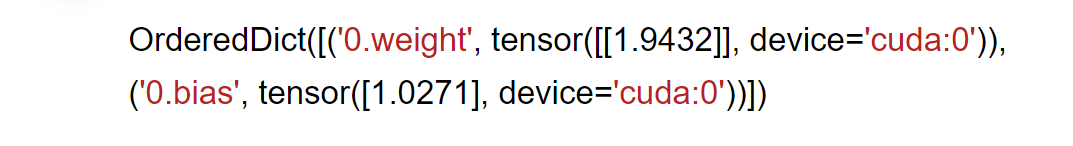

太好了，这些是我们训练模型的权重。让我们进一步训练它。在“重新思考训练循环”一章中，我们只能再训练 200 个时期，因为时期的数量是硬编码的。然而，由于我们的 StepByStep 类，我们现在可以灵活地为任意多的 epoch 训练模型。但我们仍然缺少一件事：数据！首先，我们需要设置数据加载器，然后我们可以再训练我们的模型，比如 50 个时期。

In [43]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)


让我们看看损失：

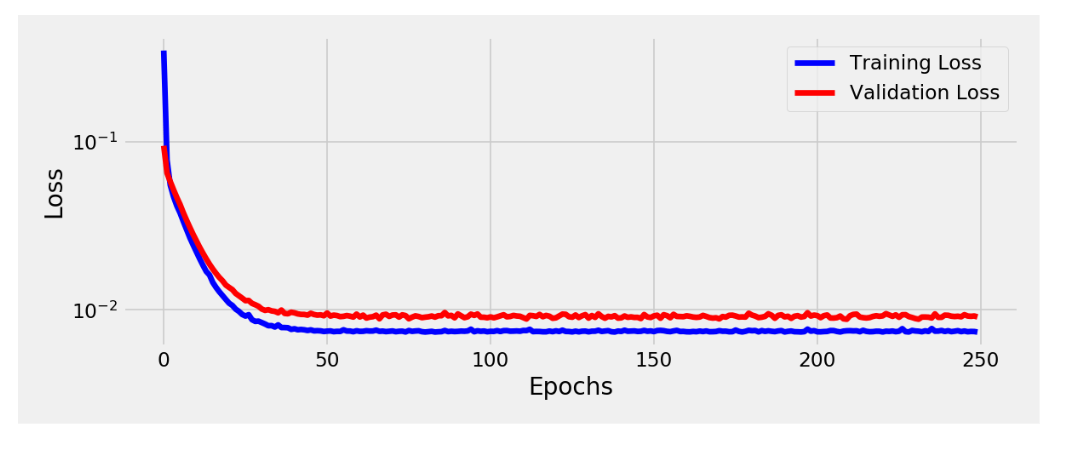

我们现在有超过 250 个时期的损失值。前 200 个 epoch 的损失是从检查点加载的，最后 50 个 epoch 的损失是在恢复训练后计算的。再一次，在“重新思考训练循环”一章中，损失的总体水平没有太大变化。

如果损失没有变化，则意味着训练损失已经最小。因此，我们预计权重将保持不变。让我们检查一下：

In [44]:
# Checking sbs model parameters
print(sbs.model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


# Putting It All Together 
## 本章总览
在本章中，我们对训练管道进行了大量修改。尽管数据准备部分没有改变，但模型配置部分被简化到最低限度，模型训练部分完全集成到 StepByStep 类中。换句话说，我们的管道很优雅。
##  数据准备V2
数据准备部分与之前完全相同，如下所示：

In [45]:
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

## 模型配置 V4 
在模型配置代码中，我们剥离了 train_step 和 val_step 函数、 SummaryWriter 和模型图，只保留了我们需要作为参数传递给 StepByStep 类的元素：模型、损失函数和优化器。

In [46]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model
model = nn.Sequential(nn.Linear(1, 1))

# Defines a SGD optimizer to update the parameters 
# (now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

## 模型训练
在模型训练中，我们首先使用相应的参数实例化 StepByStep 类。接下来，我们使用适当命名的函数 set_loaders 设置它的加载器。然后，我们设置了一个与 TensorBoard 的接口，并将我们的实验命名为 classy。然后我们使用我们设置的时期训练模型：

In [47]:
n_epochs = 200

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')
sbs.train(n_epochs=n_epochs)

最后，检查模型的状态给我们：

In [48]:
# Checking model parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


GPU 用户将获得类似于以下内容的输出：

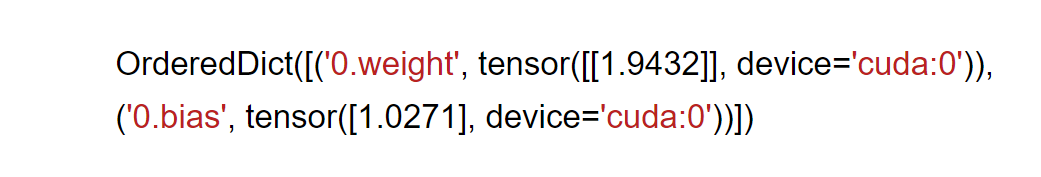

# overview
在本章中，我们重新访问并重新实现了许多方法，这正是我们所涵盖的内容：
- 定义我们的 StepByStep 类。
- 了解构造函数 ( __init__ ) 方法的用途。
- 定义构造方法的参数。
- 定义类的属性来存储我们需要跟踪的参数、占位符和变量。
- 使用高阶函数和类的属性将函数定义为属性，以构建执行训练和验证步骤的函数。
- 了解公共、受保护和私有方法之间的区别；以及 Python 的“宽松”方法。
- 创建方法来设置数据加载器和 TensorBoard 集成。
- （重新）实施培训方法： _mini_batch 和 train 。
- 实现一种进行预测的方法，该方法负责处理有关 Numpy 到 PyTorch 转换和返回的所有样板代码。
- 实现保存和加载方法： save_checkpoint 和 load_checkpoint 。
- 实现绘制损失的方法，并将模型的图形添加到 TensorBoard。
- 实例化我们的 StepByStep 类并运行经典管​​道：配置模型、加载数据、训练模型、进行预测、检查点和恢复训练。整整九码！

恭喜！您已经开发了一个功能齐全的类，它实现了与模型训练和评估相关的所有方法。从现在开始，我们将一遍又一遍地使用它来处理不同的任务和模型。